In [25]:
%matplotlib inline
import numpy as np
import scipy.io as scio
from scipy.io import loadmat
import pandas as pd
from pts_loader import load
import cv2
from matplotlib import pyplot as plt
import argparse
from imutils import face_utils
import imutils
import dlib
import cv2
import os
import sys
import math
from scipy.stats import uniform, reciprocal,norm
import random



from vanilamodel import PoseVanila
from imageaugmenter import ImageAugmenter

In [2]:
def show_image(img):
    plt.axis("off")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

### 3d Model

In [3]:
class FaceModel:
    def load_model(self, path, name):
        model = scio.loadmat(path)[name]
        self.out_A = np.asmatrix(model['outA'][0, 0], dtype='float32') #3x3
        self.size_U = model['sizeU'][0, 0][0] #1x2
        self.model_TD = np.asarray(model['threedee'][0,0], dtype='float32') #68x3
        self.indbad = model['indbad'][0, 0]#0x1
        self.ref_U = np.asarray(model['refU'][0,0])
        self.facemask = np.asarray(model['facemask'][0,0])
        self.facemask-=1 #matlab indexing

In [4]:
model = FaceModel()

In [5]:
model.load_model("../model3D_aug_-00_00_01.mat","model3D")

## Face detector

In [6]:
shape_predictor = "../shape_predictor_68_face_landmarks.dat"
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor)

### Vanila model

In [7]:
vanila_model = PoseVanila( model.out_A, model.model_TD, detector, predictor)

### generate test set

In [8]:
def grab_images(root_path, sampel=sys.maxsize):
    files_collection = []
    for root, dirs, files in os.walk(root_path, topdown=False):
        for name in files:
            files_collection.append(os.path.abspath(os.path.join(root, name)))
            if(len(files_collection) >= sampel):
                return files_collection
            
    return files_collection

In [9]:
def genrate_simple_trainning_data(root_path, sample, model):
    files = grab_images(root_path, sample)
    data = []
    
    for image_path in files:
        image = cv2.imread(image_path)
        vec_6dof = model.predict(image)
        if(vec_6dof is not None):
            data.append([image_path, *vec_6dof])
        
    df = pd.DataFrame(data, columns = ['image_path', "rx","ry","rz","tx","ty","tz"]) 
    return df

In [10]:
training_set_df = genrate_simple_trainning_data("../dataset/thumbnails128x128/",100, vanila_model)

In [11]:
training_set_df

,image_path,rx,ry,rz,tx,ty,tz
0,/mnt/notebooks/Project - Pose/dataset/thumbnai...,0.149990,0.032534,-0.008162,-94.254265,-73.570178,5612.570498
1,/mnt/notebooks/Project - Pose/dataset/thumbnai...,0.048785,-0.086957,0.000416,-94.016053,-71.793168,5655.891028
2,/mnt/notebooks/Project - Pose/dataset/thumbnai...,0.204842,0.061677,0.002724,-89.728875,-72.011765,5477.579256
3,/mnt/notebooks/Project - Pose/dataset/thumbnai...,0.286556,0.014994,-0.007937,-91.611427,-72.648123,5518.430722
4,/mnt/notebooks/Project - Pose/dataset/thumbnai...,0.145421,-0.023829,-0.007007,-92.805020,-72.203525,5532.478848
...,...,...,...,...,...,...,...
95,/mnt/notebooks/Project - Pose/dataset/thumbnai...,0.227592,0.255542,0.062923,-85.029353,-69.752190,5297.760433
96,/mnt/notebooks/Project - Pose/dataset/thumbnai...,0.162203,-0.420179,-0.055591,-102.000772,-73.571817,5661.402206
97,/mnt/notebooks/Project - Pose/dataset/thumbnai...,-0.008967,0.111208,0.000555,-90.539561,-70.158129,5544.218322
98,/mnt/notebooks/Project - Pose/dataset/thumbnai...,0.090940,0.011197,0.013808,-80.622984,-59.267721,4887.727784


In [12]:
def to_vec(df):
    data = []
    for i, row in df.iterrows():
        data.append([row['image_path'],np.array([row["rx"],row["ry"],row["rz"]])])
    return np.array(data)

In [13]:
training_set = to_vec(training_set_df)

In [96]:
training_set

array([['/mnt/notebooks/Project - Pose/dataset/thumbnails128x128/07000/07062.png',
        array([ 0.14999004,  0.03253368, -0.00816207])],
       ['/mnt/notebooks/Project - Pose/dataset/thumbnails128x128/07000/07343.png',
        array([ 0.04878462, -0.08695672,  0.00041621])],
       ['/mnt/notebooks/Project - Pose/dataset/thumbnails128x128/07000/07608.png',
        array([0.20484225, 0.06167659, 0.00272402])],
       ['/mnt/notebooks/Project - Pose/dataset/thumbnails128x128/07000/07973.png',
        array([ 0.28655573,  0.01499442, -0.00793711])],
       ['/mnt/notebooks/Project - Pose/dataset/thumbnails128x128/07000/07599.png',
        array([ 0.14542132, -0.02382949, -0.00700681])],
       ['/mnt/notebooks/Project - Pose/dataset/thumbnails128x128/07000/07658.png',
        array([0.27034219, 0.04510911, 0.02216523])],
       ['/mnt/notebooks/Project - Pose/dataset/thumbnails128x128/07000/07792.png',
        array([ 0.22280592, -0.20303405, -0.02378051])],
       ['/mnt/notebooks/Pr

In [14]:
augmantor = ImageAugmenter(vanila_model)

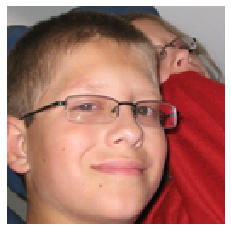

In [15]:
image_path = training_set[58][0]
image = cv2.imread(image_path)
show_image(image)

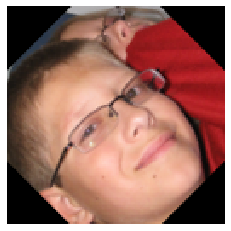

array([-1.77262351e-01, -3.03692199e-01, -8.44963057e-01, -6.70382076e+01,
       -6.07250787e+01,  4.89903107e+03])

In [16]:
img, dof = augmantor.generate_sample(image, 45, 1)
show_image(img)
dof

In [97]:
def draw_augmentations(max_rotation, size):
    scales = uniform.rvs(loc=0.75, scale=0.5, size=size)
    mu, sigma = 0.5, 1 # mean and standard deviation
    rotations = np.random.normal(mu, sigma, size)
    #normalize values between 0 and 1
    rotations = rotations / (mu + sigma*3)
    rotations = rotations * max_rotation
    return list(zip(scales, rotations))

In [64]:
mu, sigma = 0.5, 0.5 # mean and standard deviation
a = np.random.normal(mu, sigma, 4000)

In [65]:
b = a/ max(a.max(), abs(a.min()))

In [66]:
b.min()

-0.8181056195409628

In [67]:
b.max()

1.0

In [35]:
draw = draw_augmentations(max_rotation= 30, size=10)

In [36]:
for d in draw:
    print(d)

(0.955701945051012, 15.119132904830524)
(0.8905698464088087, 0.4605196701017114)
(1.0645607167091797, -0.6509825244523354)
(0.7975123390745864, -8.194948132863336)
(0.9533279060602646, -17.99656590589749)
(1.1465923691194841, 11.042983707227684)
(1.2191362462580357, 15.784093589094375)
(1.099702432301021, 13.797284399495705)
(1.0037913116574158, -0.9507884705485593)
(1.2359358969301315, 2.0447707027477993)


## Generate aug

In [20]:
!pwd

/mnt/notebooks/Project - Pose/PoseNet


In [103]:
try:
    output_dir = "/mnt/notebooks/Project - Pose/PoseNet/train/t3/"
    os.makedirs(output_dir)
except:
    pass


In [104]:
variations = draw_augmentations(max_rotation=30, size=100000)

In [99]:
def generate_augmentations(images_path, num_of_images, variations ,augmantor,output_dir, aug_per_img=3):
    images = []
    files = grab_images(images_path, num_of_images)

    for image_path in files:
#         image_name = image_path.
        image = cv2.imread(image_path)
#         show_image(image)
        for i in range(aug_per_img):
            index = random.randint(0,len(variations) -1)
            scale, rotation = variations[index]
            img, dof = augmantor.generate_sample(image, rotation, scale)
            file_path = "{}/{}_{}.png".format(output_dir, i, index)
            cv2.imwrite(file_path,img)
            images.append([file_path, *dof])

            df = pd.DataFrame(images, columns = ['image_path', "rx","ry","rz","tx","ty","tz"]) 
    return df



In [105]:
df_aug = generate_augmentations("../dataset/thumbnails128x128/", 30000, variations, augmantor, output_dir, aug_per_img = 5)

In [106]:
df_aug.to_csv("{}/training_set.pkl".format(output_dir))

In [102]:
"{}/training_set.pkl".format(output_dir)

'/mnt/notebooks/Project - Pose/PoseNet/train/t2//training_set.pkl'

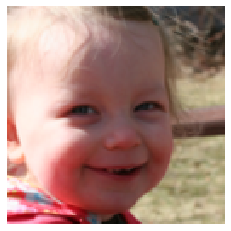

[ 0.42487251  0.03007409 -0.03357876]


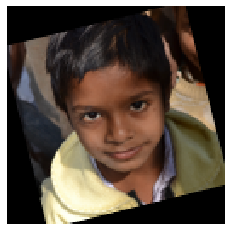

[ 0.43045645 -0.01069163 -0.23889138]


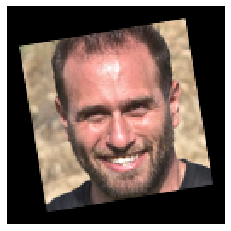

[ 0.42895737  0.00452825 -0.16259182]


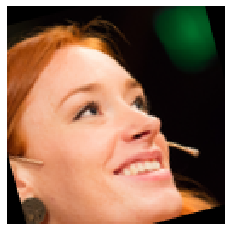

[ 0.26887401  0.01869414 -0.26468651]


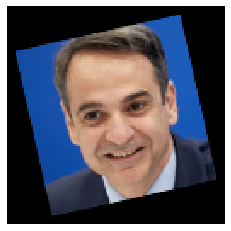

[ 0.26881952  0.02358093 -0.22205629]


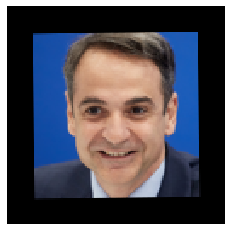

[ 0.26152465  0.04708938 -0.0182472 ]


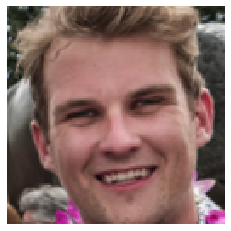

[ 0.10983634  0.02250478 -0.1760247 ]


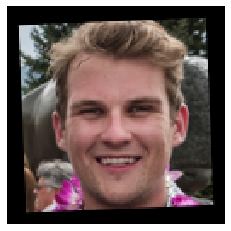

[ 0.10801707  0.02725312 -0.04640935]


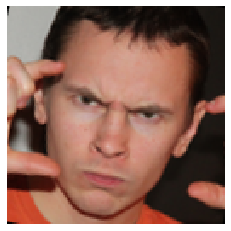

[0.09741005 0.03650964 0.21621053]


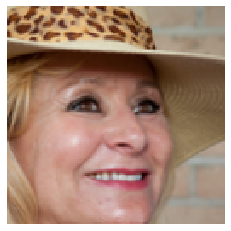

[ 0.02186142 -0.42270572 -0.07156071]


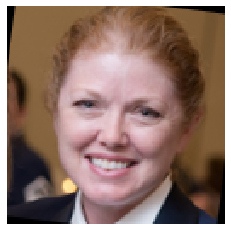

[ 0.04431621 -0.42267572  0.04075415]


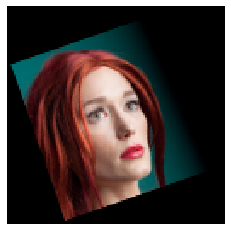

[-0.04294622 -0.41780447 -0.40747394]


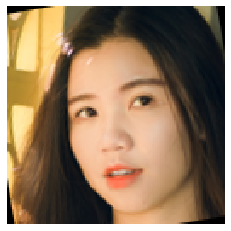

[ 0.11123255  0.26803234 -0.16177297]


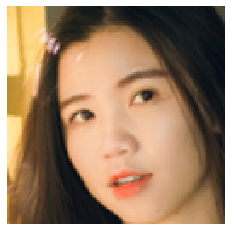

[ 0.1258427  0.2640939 -0.2634379]


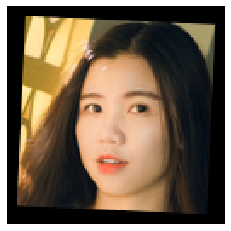

[0.08005841 0.27465735 0.04774249]


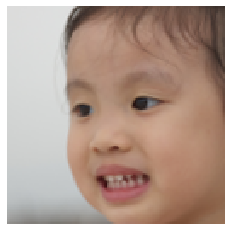

[ 0.12123018  0.38643195 -0.07055337]


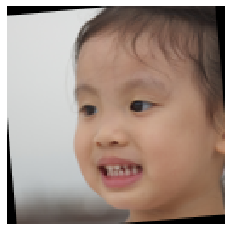

[ 0.11598863  0.38767228 -0.04099052]


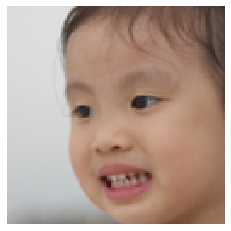

[ 0.13094292  0.38447218 -0.11574617]


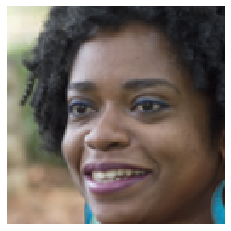

[0.07210255 0.35990068 0.02312038]


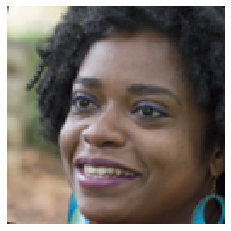

[0.0376043  0.36259154 0.19621223]


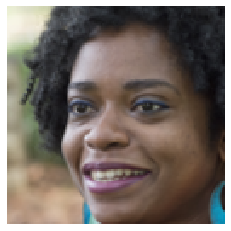

[0.06887035 0.36023665 0.03951227]


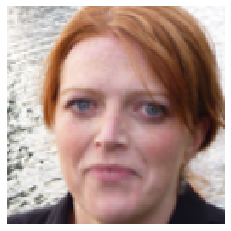

[0.08981998 0.13568243 0.07751252]


In [80]:
for i, row in df_aug[345:367].iterrows():
    image = cv2.imread(row['image_path'])

    show_image(image)
    print(np.array([row["rx"],row["ry"],row["rz"]]))